In [5]:
from nnet import CRNN
from pl_trainer import SEDTask4_2021
from utils.encoder import ManyHotEncoder
from utils.utils import batched_decode_preds
import scipy
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import torchaudio
import librosa
import librosa.display
import time
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import h5py
from IPython.display import Audio
from processing.sampler import ConcatDatasetBatchSampler
import torch
import soundata
from tqdm import tqdm
import speechbrain as sb
%matplotlib inline

In [6]:
from processing.datasets import ConcatDatasetUrban, HDF5_dataset

In [7]:
with open("../config/sed_bis.yaml", "r") as f:
        conf = yaml.safe_load(f)

In [8]:
with open(f"../config/taxonomy_SONYC.yaml", "r") as f:
    taxonomy_sn = yaml.safe_load(f)

with open(f"../config/taxonomy_SINGA-PURA.yaml", "r") as f:
    taxonomy_sgp = yaml.safe_load(f)

    
taxonomy_coarse_sn = taxonomy_sn["coarse"]
taxonomy_fine_sn = taxonomy_sn["fine"]
taxonomy_coarse_sgp = taxonomy_sgp["coarse"]
taxonomy_fine_sgp = taxonomy_sgp["fine"]

encoder_fine_sn = ManyHotEncoder(
        taxonomy_sn,
        use_taxo_fine=True,
        audio_len=conf["data"]["audio_max_len"],
        frame_len=conf["features"]["n_filters"],
        frame_hop=conf["features"]["hop_length"],
        net_pooling=conf["data"]["net_subsample"],
        fs=conf["data"]["fs"],
    )
encoder_coarse_sn = ManyHotEncoder(
        taxonomy_sn,
        use_taxo_fine=False,
        audio_len=conf["data"]["audio_max_len"],
        frame_len=conf["features"]["n_filters"],
        frame_hop=conf["features"]["hop_length"],
        net_pooling=conf["data"]["net_subsample"],
        fs=conf["data"]["fs"],
    )
encoder_fine_sgp = ManyHotEncoder(
        taxonomy_sgp,
        use_taxo_fine=True,
        audio_len=conf["data"]["audio_max_len"],
        frame_len=conf["features"]["n_filters"],
        frame_hop=conf["features"]["hop_length"],
        net_pooling=conf["data"]["net_subsample"],
        fs=conf["data"]["fs"],
    )
encoder_coarse_sgp = ManyHotEncoder(
        taxonomy_sgp,
        use_taxo_fine=False,
        audio_len=conf["data"]["audio_max_len"],
        frame_len=conf["features"]["n_filters"],
        frame_hop=conf["features"]["hop_length"],
        net_pooling=conf["data"]["net_subsample"],
        fs=conf["data"]["fs"],
    )

### Compute fine to coarse taxonomy matrix

In [9]:
import torchmetrics
torchmetrics.__version__

'0.11.0'

In [14]:
encoder = encoder_fine_sgp
classes_fine = encoder.taxonomy_fine["class_labels"]
classes_coarse = encoder.taxonomy_coarse["class_labels"]
t_matrix = np.zeros((len(classes_fine), len(classes_coarse)))

for k in encoder.taxonomy_fine["SONYC"].keys():
    c_fine = encoder.taxonomy_fine["SONYC"][k]
    if c_fine == "no-annotation":
        continue
    c_coarse = encoder.taxonomy_coarse["SONYC"][k]
    idx_fine = classes_fine.index(c_fine)
    idx_coarse = classes_coarse.index(c_coarse)
    
    t_matrix[idx_fine, idx_coarse] = 1

for k in encoder.taxonomy_fine["SINGA-PURA"].keys():
    c_fine = encoder.taxonomy_fine["SINGA-PURA"][k]
    c_coarse = encoder.taxonomy_coarse["SINGA-PURA"][k]
    if c_fine == "no-annotation":
        continue
    idx_fine = classes_fine.index(c_fine)
    idx_coarse = classes_coarse.index(c_coarse)
    
    t_matrix[idx_fine, idx_coarse] = 1


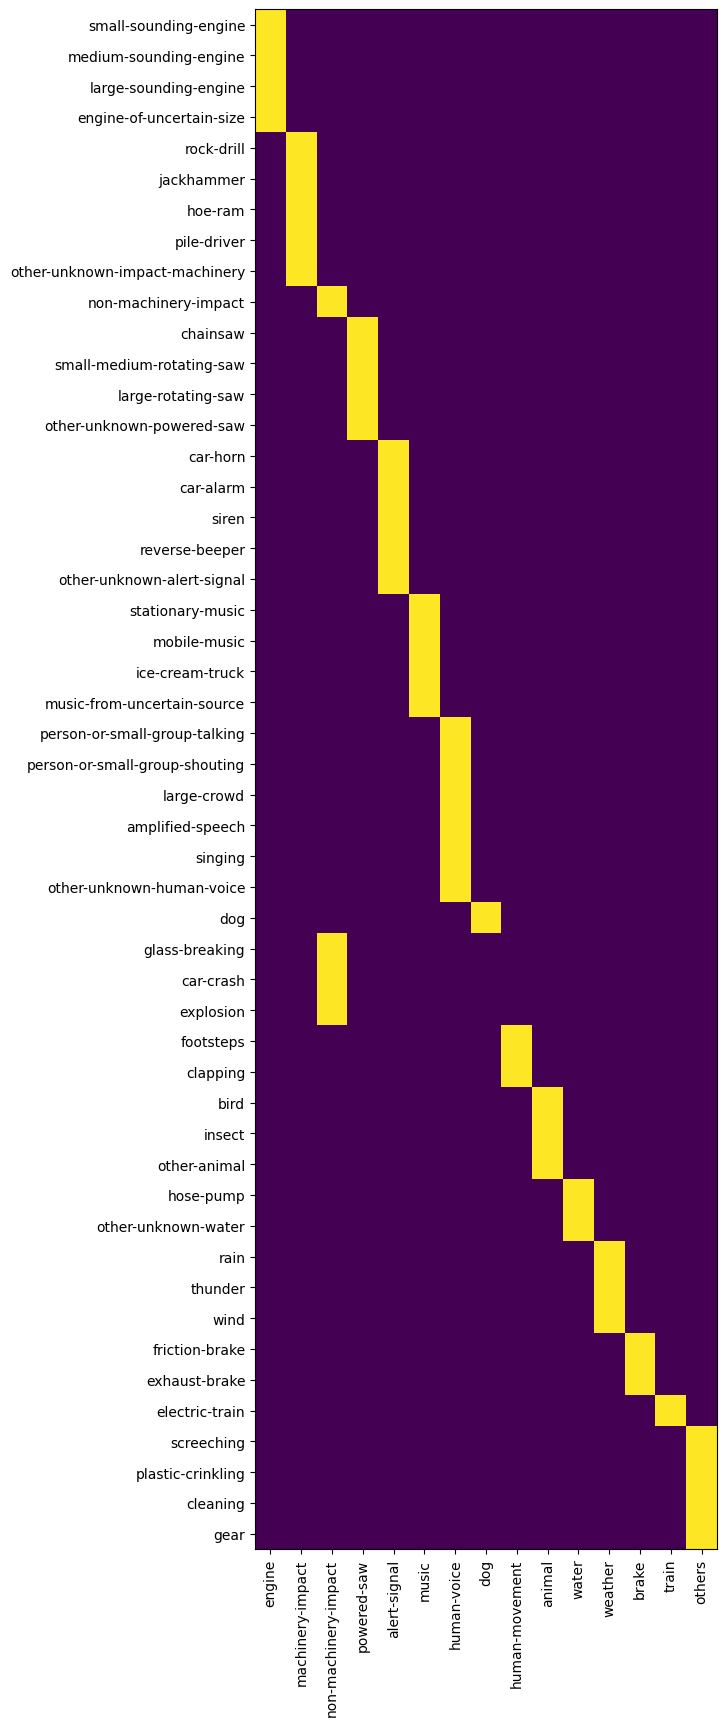

In [17]:
plt.figure(figsize=(20,20))
plt.xticks(ticks=range(len(classes_coarse)), labels=classes_coarse, rotation='vertical')
plt.yticks(ticks=range(len(classes_fine)),labels=classes_fine)
plt.imshow(t_matrix)
plt.show()

### Compute time streching matrix

In [81]:
encoder = ManyHotEncoder(
        taxonomy_sn,
        use_taxo_fine=False,
        audio_len=conf["data"]["audio_max_len"],
        frame_len=conf["features"]["n_filters"],
        frame_hop=conf["features"]["hop_length"],
        net_pooling=conf["data"]["net_subsample"],
        fs=conf["data"]["fs"],
    )

In [86]:
encoder2 = ManyHotEncoder(
        taxonomy_sn,
        use_taxo_fine=False,
        audio_len=conf["data"]["audio_max_len"],
        frame_len=conf["features"]["n_filters"],
        frame_hop=415,
        net_pooling=conf["data"]["net_subsample"],
        fs=conf["data"]["fs"],
    )
print(encoder3.n_frames)

192


In [87]:
encoder3 = ManyHotEncoder(
        taxonomy_sn,
        use_taxo_fine=False,
        audio_len=conf["data"]["audio_max_len"],
        frame_len=conf["features"]["n_filters"],
        frame_hop=830,
        net_pooling=conf["data"]["net_subsample"],
        fs=conf["data"]["fs"],
    )
print(encoder2.n_frames)

192


In [136]:
def get_rescale_matrix(encoder_in, encoder_out):
    
    if encoder_in.n_frames == encoder_out.n_frames:
        return np.eye(encoder_in.n_frames, encoder_out.n_frames)
    decim = np.ceil(encoder_out.n_frames / encoder_in.n_frames).astype(int)     
    r_matrix = torch.zeros(encoder_in.n_frames, encoder_out.n_frames * decim)
    for i in range(r_matrix.shape[1]):
        lookup = min(encoder_in.n_frames-1,int(encoder_in._time_to_frame(decim * encoder_out._frame_to_time(i))))
        r_matrix[lookup, i] = 1
    
    return r_matrix[:, ::decim]

In [137]:
def get_rescale_matrix(encoder_in, encoder_out):
    
    if encoder_in.n_frames == encoder_out.n_frames:
        return np.eye(encoder_in.n_frames, encoder_out.n_frames)
    elif encoder_in.n_frames >= encoder_out.n_frames:
        coarse_encoder = encoder_out
        fine_encoder = encoder_in
        transpose = True
    else:
        fine_encoder = encoder2
        coarse_encoder = encoder_in
        transpose = False
    
    r_matrix = torch.zeros(coarse_encoder.n_frames, fine_encoder.n_frames)
    for i in range(r_matrix.shape[1]):
        lookup = min(coarse_encoder.n_frames-1,int(coarse_encoder._time_to_frame(fine_encoder._frame_to_time(i))))
        r_matrix[lookup, i] = 1
    
    
    
    return r_matrix.T if transpose else r_matrix

In [146]:
r_matrix1 = get_rescale_matrix(encoder, encoder2).numpy()
r_matrix2 = get_rescale_matrix(encoder2, encoder3).numpy()
r_matrix3 = get_rescale_matrix(encoder, encoder3).numpy()


In [150]:
r_matrix_bis = get_rescale_matrix2(encoder, encoder3).numpy()

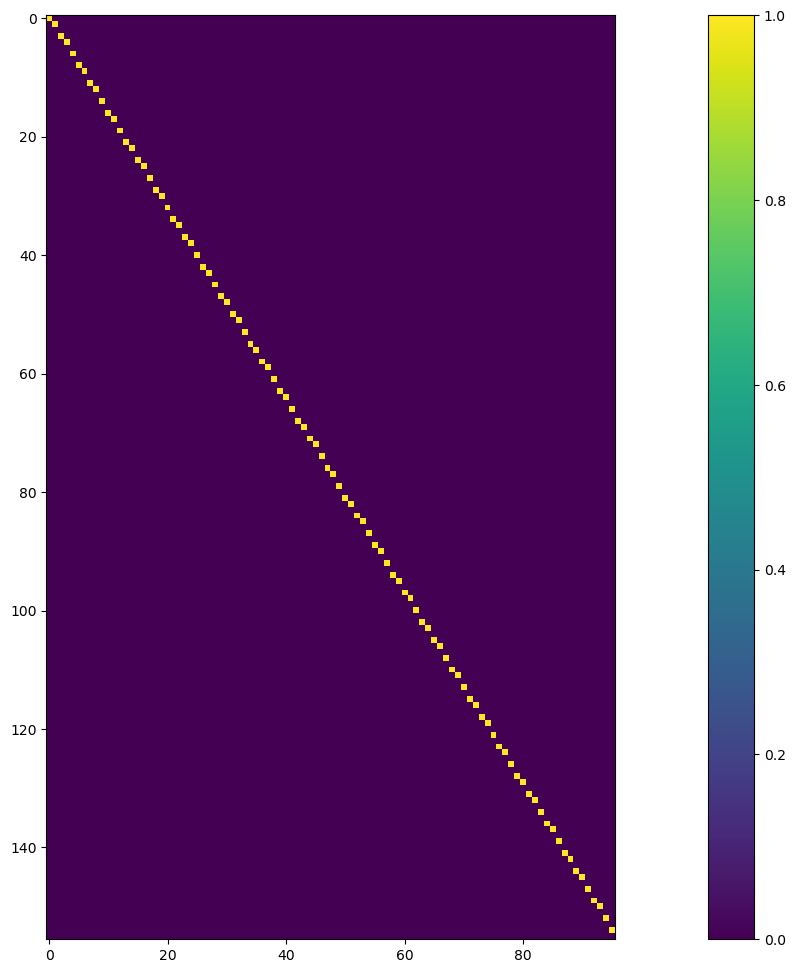

In [148]:
plt.figure(figsize=(24,12))
plt.imshow(r_matrix_bis)
plt.colorbar()

In [149]:
hf["SINGA-PURA"]["groundtruth"]["taxonomy_coarse_SINGA-PURA"][10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Test torchmetrics

In [9]:
import torchmetrics

f1_micro = torchmetrics.F1Score(
            len(encoder_coarse_sn.labels),
            average="micro",
            threshold=0.5
)       

f1_weighted = torchmetrics.F1Score(
    len(encoder_coarse_sn.labels),
    average="weighted",
    threshold=0.5
)

auroc_micro = torchmetrics.AUROC(
    len(encoder_coarse_sn.labels),
    average="micro",
)       

auroc_weighted = torchmetrics.AUROC(
    len(encoder_coarse_sn.labels),
    average="weighted",
)

ap_micro = torchmetrics.AveragePrecision(
    len(encoder_coarse_sn.labels),
    average="micro",
)

ap_weighted = torchmetrics.AveragePrecision(
    len(encoder_coarse_sn.labels),
    average="weighted",
)


label_ranking = torchmetrics.LabelRankingAveragePrecision()

weak_metrics = torchmetrics.MetricCollection(
    {
        'micro_F1_score': f1_micro,
        'weighted_F1_score': f1_weighted,
        'auroc_micro':auroc_micro,
        'auroc_weighted':auroc_weighted,
        'ap_micro':ap_micro,
        'ap_weighted':ap_weighted,
        'label_ranking':label_ranking,
    }

)

roc_curve = torchmetrics.ROC(
    num_classes=len(encoder_coarse_sn.labels),
    pos_label=1
)

pr_curve = torchmetrics.PrecisionRecallCurve(
    num_classes=len(encoder_coarse_sn.labels),
    pos_label=1
)

weak_metric_curves = torchmetrics.MetricCollection(
    {
    'roc_curve': roc_curve,
    'pr_curve': pr_curve,
    }
)

/linkhome/rech/genltc01/ufg11lw/.conda/envs/jupyter/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/linkhome/rech/genltc01/ufg11lw/.conda/envs/jupyter/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [11]:
preds = torch.rand(500,len(encoder_coarse_sn.labels))
targets = torch.randint(2, (500, len(encoder_coarse_sn.labels)))

weak_metric_curves.update(preds,targets)

In [12]:
res = weak_metric_curves.compute()

In [13]:
fpr, tpr, thresh = res['roc_curve']

In [15]:
fpr[0].shape

torch.Size([501])

### HDF5 Dataset

In [21]:
SINGAPURA_train_set = HDF5_dataset(conf["data"]["root_path"] + conf["data"]["hdf5_train"], "SINGA-PURA", encoder)
unlabelled_SINGAPURA_train_set = HDF5_dataset(conf["data"]["root_path"] + conf["data"]["hdf5_train"], "unlabelled_SINGA-PURA", encoder)
SONYC_train_set = HDF5_dataset(conf["data"]["root_path"] + conf["data"]["hdf5_train"], "SONYC", encoder)
SINGAPURA_val_set = HDF5_dataset(conf["data"]["root_path"] + conf["data"]["hdf5_val"], "SINGA-PURA", encoder)
SONYC_val_set = HDF5_dataset(conf["data"]["root_path"] + conf["data"]["hdf5_val"], "SONYC", encoder)
SINGAPURA_test_set = HDF5_dataset(conf["data"]["root_path"] + conf["data"]["hdf5_test"], "SINGA-PURA", encoder)
SONYC_test_set = HDF5_dataset(conf["data"]["root_path"] + conf["data"]["hdf5_test"], "SONYC", encoder)

In [5]:
batch_sizes = conf["training"]["batch_size"]
batch_sizes = [12,12,24]
bs = []
tot_train_data = []
if batch_sizes[0] > 0:
    tot_train_data.append(SINGAPURA_train_set)
    bs.append(batch_sizes[0])
if batch_sizes[1] > 0:
    tot_train_data.append(SONYC_train_set)
    bs.append(batch_sizes[1])
if batch_sizes[2] > 0:
    tot_train_data.append(unlabelled_SINGAPURA_train_set)        
    bs.append(batch_sizes[2])


samplers = [torch.utils.data.RandomSampler(x) for x in tot_train_data]
train_dataset = ConcatDatasetUrban(tot_train_data, encoder, batch_sizes=batch_sizes)
if len(bs) > 1:
    batch_sampler = ConcatDatasetBatchSampler(samplers, bs)
else:
    batch_sampler = torch.utils.data.BatchSampler(samplers[0], bs[0], drop_last=True)

valid_dataset = ConcatDatasetUrban([SINGAPURA_val_set, SONYC_val_set], encoder, [conf["training"]["batch_size_val"]])

test_dataset = ConcatDatasetUrban([SINGAPURA_test_set, SONYC_test_set], encoder, [conf["training"]["batch_size_val"]])

NameError: name 'SINGAPURA_train_set' is not defined

In [23]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_sampler=batch_sampler,
    collate_fn=train_dataset.collate_fn,
    num_workers=4
)

val_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=conf["training"]["batch_size_val"],
    num_workers=4,
    shuffle=False,
    drop_last=False,
    collate_fn=valid_dataset.collate_fn,
)

In [24]:
loader = train_loader if 1 else val_loader
dataiter = iter(loader)

opening hdf5opening hdf5opening hdf5opening hdf5





### Test Audio Normalization and PCEN/Leaf from Speechbrain

In [25]:
from utils.scaler import TorchScaler
feat_params = conf["features"]
mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=feat_params["sample_rate"],
            n_fft=feat_params["n_window"],
            win_length=feat_params["n_window"],
            hop_length=feat_params["hop_length"],
            center=True,
            pad_mode="reflect",
            power=1.0,
            f_min=feat_params["f_min"],
            f_max=feat_params["f_max"],
            n_mels=feat_params["n_mels"],
            window_fn=torch.hamming_window,
            norm='slaney',
            onesided=True,
            mel_scale="htk",
        )

In [26]:
def take_log(mels):
        """ Apply the log transformation to mel spectrograms.
        Args:
            mels: torch.Tensor, mel spectrograms for which to apply log.

        Returns:
            Tensor: logarithmic mel spectrogram of the mel spectrogram given as input
        """        
        
        return (1e-5+mels).log()
        
        #amp_to_db = torchaudio.transforms.AmplitudeToDB(stype="amplitude")
        #amp_to_db.amin = 1e-5  # amin= 1e-5 as in librosa
        #return amp_to_db(mels)#.clamp(min=-50, max=120)  # clamp to reproduce old code

In [27]:
scaler = TorchScaler(batch_sizes,
                "instance",
                "standard",
                (2,)
            )

In [28]:
batch = dataiter.next()


In [29]:
audio, labels, filenames = batch
features = mel_spec(audio)

In [30]:
def normalize(tensor, type_mask):
    dims = (2,)
    if type_mask == "strong":
        return tensor - torch.mean(tensor, dims, keepdim=True)
    elif type_mask == "weak":
        return (tensor - torch.mean(tensor, dims, keepdim=True)) / (
            torch.std(tensor, dims, keepdim=True) + 1e-15
        )
    elif type_mask == "unlab":
        return (tensor - torch.amin(tensor, dim=dims, keepdim=True)) / (
            torch.amax(tensor, dim=dims, keepdim=True)
            - torch.amin(tensor, dim=dims, keepdim=True)
            + 1e-15
        )


tensor = logfeat.clone()
if torch.any(mask_strong):
    tensor[mask_strong] = normalize(tensor[mask_strong], "strong")
if torch.any(mask_weak):
    tensor[mask_weak] = normalize(tensor[mask_weak], "weak")
if torch.any(mask_unlab):
    tensor[mask_unlab] = normalize(tensor[mask_unlab], "unlab")

NameError: name 'logfeat' is not defined

In [229]:
logfeat = take_log(features)

In [230]:
indx_strong, indx_weak, indx_unlab = batch_sizes
batch_num = features.shape[0]
# deriving masks for each dataset
mask_strong = torch.zeros(batch_num).to(features).bool()
mask_weak = torch.zeros(batch_num).to(features).bool()
mask_unlab = torch.zeros(batch_num).to(features).bool()
mask_strong[:indx_strong] = 1
mask_weak[indx_strong : indx_weak + indx_strong] = 1
if indx_unlab > 0:
    mask_unlab[indx_strong + indx_weak:] = 1

In [231]:
logfeat_scaled = logfeat.clone()
logfeat_scaled = scaler(logfeat_scaled, mask_strong, mask_weak, mask_unlab)

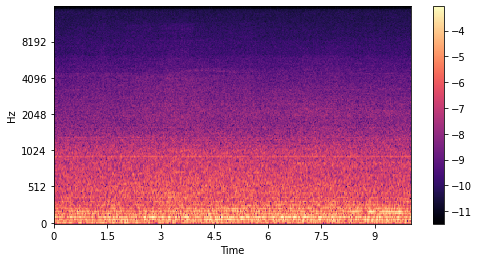

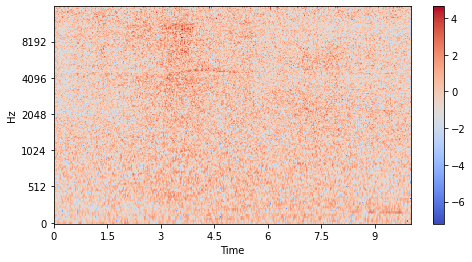

In [237]:
idx = 11

fig, ax = plt.subplots(figsize=(8,4))
img = librosa.display.specshow(logfeat[idx].numpy(), x_axis='time',
                         y_axis='mel', sr=32000,
                         fmax=16000, ax=ax)
fig.colorbar(img, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(8,4))
img = librosa.display.specshow(logfeat_scaled[idx].numpy(), x_axis='time',
                         y_axis='mel', sr=32000,
                         fmax=16000, ax=ax)
fig.colorbar(img, ax=ax)
plt.show()


Audio(audio[idx], rate=32000)

In [71]:
print(features[0,0,0],features[26,50,50],features[14,50,50])
print(logfeat[0,50,50],logfeat[28,50,50],logfeat[14,50,50])
print(logfeat_scaled[0,50,50],logfeat_scaled[28,50,50],logfeat_scaled[14,50,50])

tensor(3.4957e-05) tensor(0.0010) tensor(0.0023)
tensor(-0.4213) tensor(1.8962) tensor(-0.2818)
tensor(-0.4213) tensor(1.8962) tensor(-0.2818)


In [44]:
scaler.mean_squared_unlab

tensor([[[2489.3235],
         [2425.9685],
         [2387.0764],
         [2367.2690],
         [2229.8425],
         [2386.0115],
         [2190.4539],
         [2364.4597],
         [2321.7104],
         [2194.3162],
         [2359.0037],
         [2266.7588],
         [2364.2444],
         [2426.4717],
         [2399.1726],
         [2439.5759],
         [2458.7444],
         [2435.0081],
         [2446.3262],
         [2468.8147],
         [2466.4336],
         [2456.1074],
         [2477.6521],
         [2478.8706],
         [2476.0356],
         [2472.7183],
         [2483.3718],
         [2484.3528],
         [2484.1531],
         [2480.2334],
         [2481.5557],
         [2484.1155],
         [2483.6033],
         [2482.7693],
         [2481.9229],
         [2477.7261],
         [2473.7717],
         [2476.7310],
         [2477.4060],
         [2476.6345],
         [2475.6060],
         [2475.9775],
         [2478.0200],
         [2479.9292],
         [2480.2554],
         [

In [ ]:
scaler.fit(
            train_loader,
            transform_func=lambda x: take_log(mel_spec(x[0])),
        )

  0%|          | 0/368 [00:00<?, ?it/s]

opening hdf5opening hdf5
opening hdf5opening hdf5




In [31]:
scaler.mean_weak

tensor([[[ -8.5842],
         [  2.6103],
         [ -2.3385],
         [ -1.1640],
         [ -0.5475],
         [ -6.8015],
         [ -1.4463],
         [-12.4311],
         [-10.0988],
         [-11.8389],
         [-16.8767],
         [-15.2900],
         [-17.8473],
         [-20.0089],
         [-18.9764],
         [-22.6621],
         [-23.7740],
         [-23.5050],
         [-24.8550],
         [-26.0295],
         [-27.1134],
         [-24.6117],
         [-28.4992],
         [-27.8210],
         [-28.8068],
         [-27.9446],
         [-30.4412],
         [-30.1197],
         [-31.1185],
         [-31.3601],
         [-32.8540],
         [-33.3565],
         [-33.3048],
         [-33.7675],
         [-34.7533],
         [-34.9732],
         [-35.1875],
         [-35.2361],
         [-34.8736],
         [-34.8926],
         [-35.2533],
         [-35.7171],
         [-36.1452],
         [-36.4907],
         [-36.8273],
         [-37.1423],
         [-37.4367],
         [-37

In [17]:
batch = dataiter.next()
enter_while = False
while batch[2][0][0] == "[" and enter_while:
    enter_while = False
    batch = dataiter.next()

IndexError: tuple index out of range

In [23]:
audio, labels, filenames = batch
audio = audio.cuda()

### Test torchopenl3 and CRNN inference

In [37]:
resampler = torchaudio.transforms.Resample(32000, 48000, dtype=audio.dtype).cuda()
audio_res = resampler(audio).cuda()

In [38]:
audio_res1 = audio_res

In [42]:
model_openl3 = torchopenl3.models.load_audio_embedding_model(input_repr="mel256", content_type="env",
                                                 embedding_size=512).cuda()

In [43]:
emb, ts = torchopenl3.get_audio_embedding(audio_res, sr=48000, model=model, hop_size=0.0615)

In [44]:
emb.shape

torch.Size([12, 156, 512])

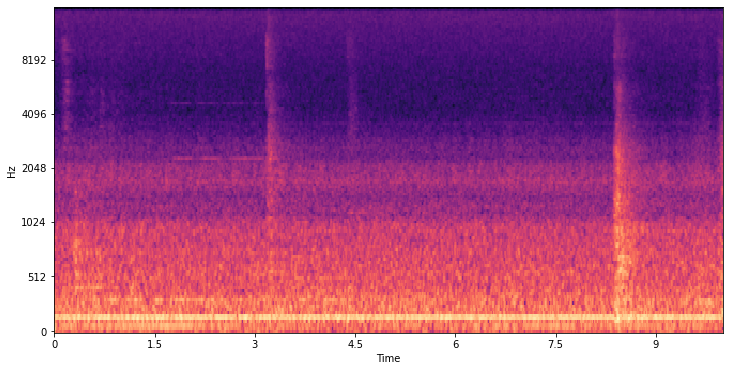

In [43]:
idx = 8
y = audio[idx].numpy()
feat_params = conf["features"]

mel_spec_2 = torchaudio.transforms.MelSpectrogram(
    sample_rate=feat_params["sample_rate"],
    n_fft=feat_params["n_window"],
    win_length=feat_params["n_window"],
    hop_length=feat_params["hop_length"],
    center=True,
    pad_mode="reflect",
    power=2.0,
    f_min=feat_params["f_min"],
    f_max=feat_params["f_max"],
    n_mels=int(feat_params["n_mels"]/2),
    window_fn=torch.hamming_window,
    norm='slaney',
    onesided=True,
    mel_scale="htk",
)

mel_spec_librosa = mel_spec_2(torch.from_numpy(y).float()).numpy()

librosa_dB = librosa.power_to_db(mel_spec_librosa, ref=np.max)

fig, ax = plt.subplots(figsize=(12,6))
librosa.display.specshow(librosa_dB, x_axis='time',
                         y_axis='mel', sr=32000,
                         fmax=16000, ax=ax)

Audio(y, rate=32000)

In [16]:
conf["net"].update({"n_class": len(encoder.labels)})
conf.update({"taxonomy": encoder.taxonomy["name"]})
print(encoder.taxonomy["name"])

taxonomy_coarse_SONYC


In [17]:
path_ckpt = "../experiments/2021_baseline/version_0/epoch=162-step=57538.ckpt"
sed_student=CRNN.CRNN(**conf["net"])
print(sed_student.parameters())
model = SEDTask4_2021.load_from_checkpoint(path_ckpt, encoder=encoder, sed_student=sed_student,hparams=conf)

<generator object Module.parameters at 0x152650306eb0>


/linkhome/rech/genltc01/ufg11lw/.conda/envs/jupyter_env/lib/python3.9/site-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `F1` was deprecated since v1.3.0 in favor of `torchmetrics.classification.f_beta.F1`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


In [33]:
with torch.no_grad():
    strong_pred, weak_pred = model(audio)

In [34]:
print(filenames[idx])
print(encoder.decode_strong(labels[idx].numpy()))
gt = val_loader.dataset.datasets[0].groundtruths
print(gt[gt["filename"]==filenames[idx]][["onset","offset","event_label"]])

[b827eb3e52b8][2020-08-23T16-45-04Z][manual][---][4edbade2d41d5f80e324ee4f10d401c0][]-1647
[['non-machinery-impact', 1.216, 1.536]]
    onset  offset           event_label
20  1.216   1.536  non-machinery-impact


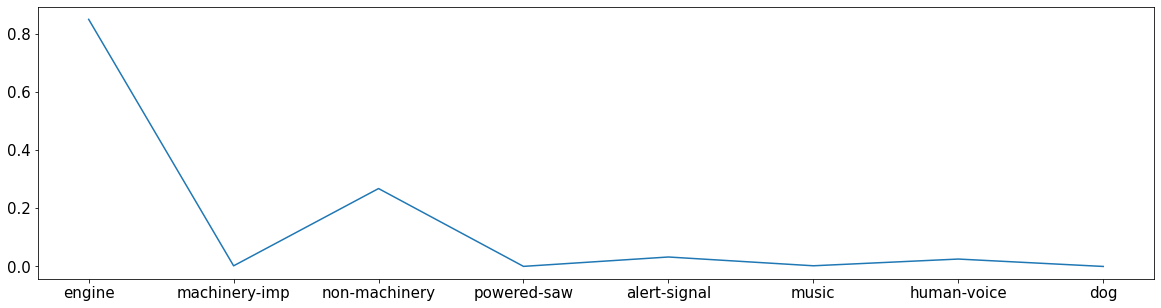

In [35]:
plt.figure(figsize=(20,5))
plt.plot(weak_pred[idx])
plt.xticks(labels=map(lambda x: x[:13], encoder.labels), ticks=list(range(len(encoder.labels))), fontsize=15)
plt.yticks(fontsize=15)
plt.show()

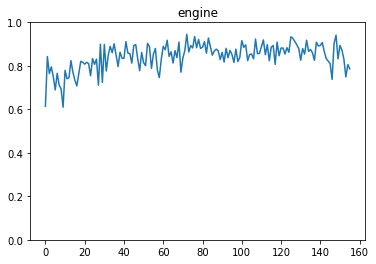

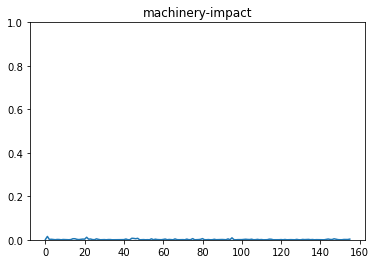

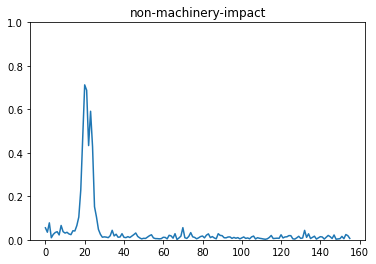

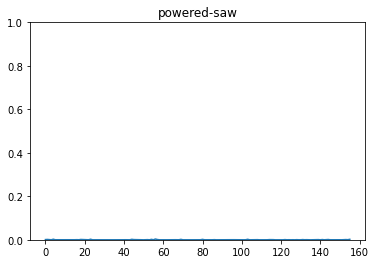

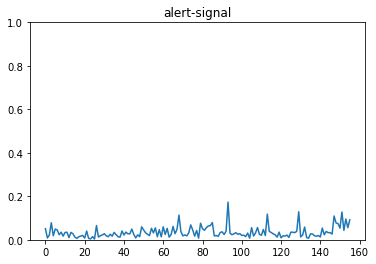

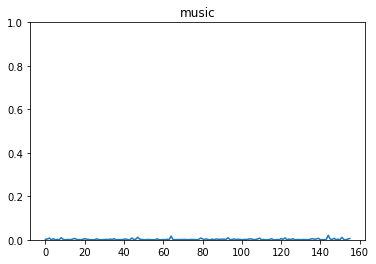

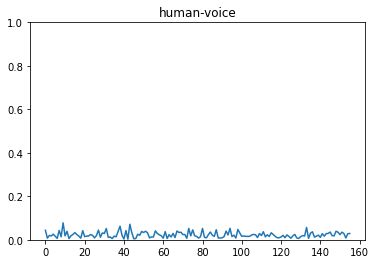

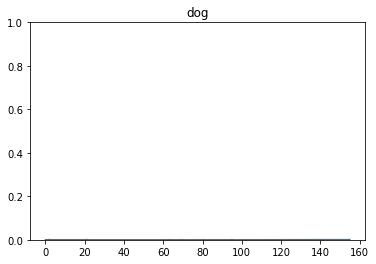

In [36]:
for i, label in enumerate(encoder.labels):
    plt.figure()
    plt.plot(strong_pred[idx, i, :].numpy())
    plt.title(label)
    plt.ylim([0,1])

In [96]:
filenames_strong = [
                x
                for x in filenames
                if x[0] == '['
            ]
mask_strong = (
    torch.tensor(
        [
            x[0] == '['
            for x in filenames
        ]
    ,device=model.device)
    .bool()
)

In [97]:
decoded_pred = batched_decode_preds(
                strong_pred[mask_strong],
                filenames_strong,
                model.encoder,
                median_filter=model.hparams["training"]["median_window"],
                thresholds=list(model.val_buffer_student_strong.keys()),
            )
df = decoded_pred[0.5]
print("predictions : ")
print(df[df["filename"]==filenames[idx]][["onset","offset","event_label"]])
print("groundtruths :")
print(gt[gt["filename"]==filenames[idx]][["onset","offset","event_label"]])

predictions : 
   onset offset  event_label
41   0.0  9.984  human-voice
groundtruths :
    onset  offset  event_label
21    0.0   9.984  human-voice


In [80]:
SINGAPURA_train_set = HDF5_SINGAPURA_labelled(
    conf["data"]["root_path"] + conf["data"]["hdf5_train"],
    conf["data"]["root_path"] + conf["data"]["singa-pura_csv_train"],
    encoder,
    return_filename=True
)

NameError: name 'HDF5_SINGAPURA_labelled' is not defined

In [46]:
hf = h5py.File(conf["data"]["root_path"] + conf["data"]["hdf5_train"], 'r')

In [47]:
for f in hf:
    print(f)

SINGA-PURA
SONYC
unlabelled_SINGA-PURA


In [49]:
group = hf["SONYC"]

In [50]:
test = group["groundtruth"][taxonomy["name"]][...]

In [51]:
print(test)
np.where(test.any(axis=(1)))[0].shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


(12978,)

In [52]:
for d in group["groundtruth"]:
    print(group["groundtruth"][d].shape)

(12978, 15)
(12978, 8)
(12978, 50)
(12978, 29)


## Computing proximity for SONYC

In [81]:
type_hf = "test"
#sonyc_gt = pd.read_csv((conf['data']["root_path"]+conf['data'][f"sonyc_csv_{type_hf}"]).replace(".csv","_extended.csv"))
#sonyc_df = pd.read_csv("../data/metadata/annotations_sonyc.csv")

In [26]:
n_unknown = 0
n_disagreement = 0
n_near = 0
n_far = 0

for i, row in tqdm(sonyc_gt.iterrows()):
    prox = row["proximity"]
    if isinstance(prox,float):
        continue
    prox = prox.split(";")
    n_unknown += prox.count("-1")
    n_disagreement += prox.count("ambiguous")
    n_near += prox.count("near")
    n_far += prox.count("far")

print(f"n_unknown = {n_unknown}, n_disagreement = {n_disagreement}, n_near = {n_near}, n_far = {n_far}")

12978it [00:00, 25715.54it/s]

n_unknown = 18927, n_disagreement = 1770, n_near = 12677, n_far = 550


In [7]:
prox_col = sonyc_df.columns[41:70]
prox_ids = list(map(lambda x : x[:3], prox_col))

In [30]:
for i, row in sonyc_gt.iterrows():
    labels = row["event_labels"].split(";")
    fine_labels = list(filter(lambda x : len(x)>1, labels))
    assert len(fine_labels)  > 0

In [24]:
taxonomy_fine["SONYC"]["1-1"]

'small-sounding-engine'

In [59]:
'''
Pseudo code:

no proximity annotation : 1
near : 2
far : 3
ambiguous : 4


Parcourir le dataframe
    get filename
    get labels from metadata
    keep only fine labels
    
    for each fine labels (function):
        check proximity annotations other than -1 and notsure
        if only one : register this one
        if multiple : get max occurrence
        if two maximums : disagreement
        
        return [fine_labels, proximity]
    
    update with two new columns : fine_labels, proximity


'''
def merge_proximity_annot(l):
    n_near = l.count("near")
    n_far = l.count("far")
    
    if n_near == 0 and n_near == 0:
        return "-1"
    elif n_near > 0 and n_near > n_far:
        return "near"
    elif n_far > 0 and n_far > n_near:
        return "far"
    else:
        return "ambiguous"


proximity_list = [None]*len(sonyc_gt)
fine_labels_list = [None]*len(sonyc_gt)
for i, row in tqdm(sonyc_gt.iterrows()):
    filename = row["filename"]
    idx_label = row["event_labels"].split(";")
    indices_fine_label = list(filter(lambda x : len(x)>1, idx_label))
    local_prox_list = []
    for if_fl in indices_fine_label:
        idx_col = prox_ids.index(if_fl)
        prox_annots = list(sonyc_df[sonyc_df["audio_filename"]==filename][prox_col[idx_col]])
        local_prox_list.append(merge_proximity_annot(prox_annots))
    fine_labels_list[i] = ";".join(indices_fine_label)
    proximity_list[i] = ";".join(local_prox_list)

sonyc_gt["fine_labels"] = fine_labels_list
sonyc_gt["proximity"] = proximity_list
sonyc_gt.to_csv((conf['data']["root_path"]+conf['data'][f"sonyc_csv_{type_hf}"]).replace(".csv", "_extended.csv"), index=False)

664it [00:05, 116.00it/s]


In [57]:
print(len(sonyc_df[sonyc_df["split"] == "test"]["audio_filename"].unique()))
print(len(sonyc_df[(sonyc_df["split"] == "test") & (sonyc_df["annotator_id"] == 0)]["audio_filename"].unique()))

664
664


In [45]:
sonyc_gt.to_csv((conf['data']["root_path"]+conf['data'][f"sonyc_csv_{type_hf}"]).replace(".csv", "_extended.csv"), index=False)

In [ ]:
sonyc_gt.to_csv((conf['data']["root_path"]+conf['data'][f"sonyc_csv_{type_hf}"]).replace(".csv, _extended.csv"), index=False)

In [35]:
conf['data']["root_path"]+conf['data'][f"sonyc_csv_{type_hf}"].replace(".csv", "_extended.csv")

'/gpfsscratch/rech/gpz/ufg11lw/data_urban/metadata/train/SONYC_train_extended.csv'

## Creating proximity groundtruths for SONYC in HDF5

In [39]:
hf.close()

In [42]:
type_hf = "test"
#hf = h5py.File(conf["data"]["root_path"] + conf["data"][f"hdf5_{type_hf}"], 'r+')
#sgp_gt = pd.read_csv(f"../data/metadata/{type_hf}/SONYC_{type_hf}.csv")
hf = h5py.File(f"{conf['data']['root_path']}{type_hf}.h5", 'r+')

In [27]:
def print_hf(hf):
    def recursive_print(hf, tab):
        for name in hf:
            if isinstance(hf[name], h5py.Group):
                print(''.join(['\t']*tab) + name)
                recursive_print(hf[name], tab + 1)
            else:
                print(''.join(['\t']*tab) + str(hf[name]).replace("<HDF5 dataset", ""))
                
    recursive_print(hf, 0)

In [55]:
print_hf(hf)

SINGA-PURA
	 "audio_32k": shape (1376, 320000), type "<f4">
	 "filenames": shape (1376,), type "|O">
	groundtruth
		 "taxonomy_coarse_SINGA-PURA": shape (1376, 15, 156), type "<f8">
		 "taxonomy_coarse_SONYC": shape (1376, 8, 156), type "<f8">
		 "taxonomy_fine_SINGA-PURA": shape (1376, 50, 156), type "<f8">
		 "taxonomy_fine_SONYC": shape (1376, 29, 156), type "<f8">
	 "open_l3_512": shape (1376, 96, 512), type "<f4">
	 "passt_2levelmel": shape (1376, 201, 3358), type "<f4">
SONYC
	 "audio_32k": shape (664, 320000), type "<f4">
	 "filenames": shape (664,), type "|O">
	groundtruth
		 "taxonomy_coarse_SINGA-PURA": shape (664, 15), type "<f8">
		 "taxonomy_coarse_SONYC": shape (664, 8), type "<f8">
		 "taxonomy_fine_SINGA-PURA": shape (664, 50), type "<f8">
		 "taxonomy_fine_SONYC": shape (664, 29), type "<f8">
	groundtruth_with_proximity
		 "taxonomy_coarse_SINGA-PURA": shape (664, 15), type "<f8">
		 "taxonomy_coarse_SONYC": shape (664, 8), type "<f8">
		 "taxonomy_fine_SINGA-PURA": sh

In [69]:
encoder_fine_sn.labels[1]

'medium-sounding-engine'

In [73]:
idx = 91
print(hf["SONYC"]["groundtruth_with_proximity"]["taxonomy_fine_SONYC"][idx])
print(hf["SONYC"]["filenames"][idx])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
b'05_027485.wav'


In [43]:
group_to_copy = hf["SONYC"]["groundtruth"]
group_dest = hf["SONYC"]
ok = input("proceed to copy group ?")
if ok == "y":
    hf.copy(group_to_copy, group_dest, "groundtruth_with_proximity")

proceed to copy group ? y


RuntimeError: Unable to copy object (destination object already exists)

In [74]:
for i in hf["SONYC"]["groundtruth_with_proximity"]:
    print(i)
gt_coarse_SGP = hf["SONYC"]["groundtruth_with_proximity"]["taxonomy_coarse_SINGA-PURA"]
gt_fine_SGP = hf["SONYC"]["groundtruth_with_proximity"]["taxonomy_fine_SINGA-PURA"]
gt_fine_SONYC = hf["SONYC"]["groundtruth_with_proximity"]["taxonomy_fine_SONYC"]
gt_coarse_SONYC = hf["SONYC"]["groundtruth_with_proximity"]["taxonomy_coarse_SONYC"]

taxonomy_coarse_SINGA-PURA
taxonomy_coarse_SONYC
taxonomy_fine_SINGA-PURA
taxonomy_fine_SONYC


In [103]:
def update_prox_one_hot(prev_value, prox):
    prox_to_label = {'-1':1,
                 'near':2,
                 'far':3,
                 'ambiguous':4}
    if prev_value == 0:
        raise ValueError(f"Should not happen")
    elif prev_value == 1 or prev_value == prox_to_label[prox]:
        return prox_to_label[prox]
    elif prev_value != prox_to_label[prox]:
        return prox_to_label["ambiguous"]
    else:
        raise ValueError(f"unforeseen case : prev_value = {prev_value} and prox = {prox}")
        

In [76]:
sonyc_gt = pd.read_csv("../data/metadata/test/SONYC_test_perso.csv")

In [98]:
print(taxonomy_coarse_sn['SONYC'][fe])
print(taxonomy_fine_sn['SONYC'][fe])
print(taxonomy_fine_sgp['SONYC'][fe])
print(taxonomy_coarse_sgp['SONYC'][fe])

engine
large-sounding-engine
large-sounding-engine
engine


In [104]:
# assert len(sonyc_gt) == len(gt_coarse_SONYC)
for i, row in sonyc_gt.iterrows():
    # update each event label with corresponding proximity one hot encoding
    fine_events = row["fine_event_labels"]
    if isinstance(fine_events, float):
        continue
    else:
        fine_events = fine_events.split(";")
    proximity = row["proximity"].split(";")


    for fe, prox in zip(fine_events, proximity):
        idx_coarse_sn = encoder_coarse_sn.labels.index(taxonomy_coarse_sn['SONYC'][fe])
        idx_fine_sn = encoder_fine_sn.labels.index(taxonomy_fine_sn['SONYC'][fe])
        idx_coarse_sgp = encoder_coarse_sgp.labels.index(taxonomy_coarse_sgp['SONYC'][fe])
        idx_fine_sgp = encoder_fine_sgp.labels.index(taxonomy_fine_sgp['SONYC'][fe])
        
        one_hot_coarse_SONYC = update_prox_one_hot(gt_coarse_SONYC[i][idx_coarse_sn], prox)
        one_hot_fine_SONYC =update_prox_one_hot(gt_fine_SONYC[i][idx_fine_sn], prox)
        one_hot_coarse_SGP = update_prox_one_hot(gt_coarse_SGP[i][idx_coarse_sgp], prox)
        one_hot_fine_SGP = update_prox_one_hot(gt_fine_SGP[i][idx_fine_sgp], prox)
        
        gt_coarse_SONYC[i,idx_coarse_sn] = one_hot_coarse_SONYC
        gt_fine_SONYC[i,idx_fine_sn] = one_hot_fine_SONYC
        gt_coarse_SGP[i,idx_coarse_sgp] = one_hot_coarse_SGP
        gt_fine_SGP[i,idx_fine_sgp] = one_hot_fine_SGP
                                                                                   

3it [00:00, 922.70it/s]
2it [00:00, 1157.37it/s]
2it [00:00, 1244.05it/s]
2it [00:00, 1242.94it/s]
3it [00:00, 1357.82it/s]
2it [00:00, 1216.80it/s]
3it [00:00, 1348.07it/s]
3it [00:00, 1344.18it/s]
2it [00:00, 1228.74it/s]
3it [00:00, 1363.71it/s]
2it [00:00, 1228.56it/s]
2it [00:00, 1236.89it/s]
2it [00:00, 1223.54it/s]
2it [00:00, 1222.65it/s]
3it [00:00, 1333.08it/s]
2it [00:00, 1105.36it/s]
2it [00:00, 1240.92it/s]
3it [00:00, 1359.73it/s]
2it [00:00, 1230.00it/s]
1it [00:00, 975.19it/s]
3it [00:00, 1360.17it/s]
1it [00:00, 977.92it/s]
1it [00:00, 978.15it/s]
2it [00:00, 1232.53it/s]
1it [00:00, 964.43it/s]
2it [00:00, 1184.16it/s]
3it [00:00, 1354.46it/s]
1it [00:00, 976.78it/s]
2it [00:00, 1229.10it/s]
2it [00:00, 1234.89it/s]
2it [00:00, 1219.98it/s]
5it [00:00, 1484.29it/s]
1it [00:00, 981.12it/s]
2it [00:00, 1224.44it/s]
3it [00:00, 1337.19it/s]
1it [00:00, 977.01it/s]
2it [00:00, 1246.08it/s]
2it [00:00, 1243.13it/s]
1it [00:00, 979.06it/s]
2it [00:00, 1247.56it/s]
2it [00:0

## Creating proximity groundtruths of SGP in HDF5

In [9]:
hf.close()

NameError: name 'hf' is not defined

In [55]:
type_hf = "test"
#hf = h5py.File(conf["data"]["root_path"] + conf["data"][f"hdf5_{type_hf}"], 'r+')
hf = h5py.File(f"{conf['data']['root_path']}{type_hf}.h5", 'r+')
sgp_gt = pd.read_csv(f"../data/metadata/{type_hf}/SINGA-PURA_{type_hf}.csv")

In [28]:
print_hf(hf)

SINGA-PURA
	 "audio_32k": shape (1376, 320000), type "<f4">
	 "filenames": shape (1376,), type "|O">
	groundtruth
		 "taxonomy_coarse_SINGA-PURA": shape (1376, 15, 156), type "<f8">
		 "taxonomy_coarse_SONYC": shape (1376, 8, 156), type "<f8">
		 "taxonomy_fine_SINGA-PURA": shape (1376, 50, 156), type "<f8">
		 "taxonomy_fine_SONYC": shape (1376, 29, 156), type "<f8">
	groundtruth_with_proximity
		 "taxonomy_coarse_SINGA-PURA": shape (1376, 15, 156), type "<f8">
		 "taxonomy_coarse_SONYC": shape (1376, 8, 156), type "<f8">
		 "taxonomy_fine_SINGA-PURA": shape (1376, 50, 156), type "<f8">
		 "taxonomy_fine_SONYC": shape (1376, 29, 156), type "<f8">
	 "open_l3_512": shape (1376, 96, 512), type "<f4">
	 "passt_2levelmel": shape (1376, 201, 3358), type "<f4">
SONYC
	 "audio_32k": shape (664, 320000), type "<f4">
	 "filenames": shape (664,), type "|O">
	groundtruth
		 "taxonomy_coarse_SINGA-PURA": shape (664, 15), type "<f8">
		 "taxonomy_coarse_SONYC": shape (664, 8), type "<f8">
		 "taxon

In [63]:
for i in hf["SINGA-PURA"]["groundtruth_with_proximity"]:
    print(i)
gt_coarse_SGP = hf["SINGA-PURA"]["groundtruth_with_proximity"]["taxonomy_coarse_SINGA-PURA"]
gt_fine_SGP = hf["SINGA-PURA"]["groundtruth_with_proximity"]["taxonomy_fine_SINGA-PURA"]
gt_fine_SONYC = hf["SINGA-PURA"]["groundtruth_with_proximity"]["taxonomy_fine_SONYC"]
gt_coarse_SONYC = hf["SINGA-PURA"]["groundtruth_with_proximity"]["taxonomy_coarse_SONYC"]

taxonomy_coarse_SINGA-PURA
taxonomy_coarse_SONYC
taxonomy_fine_SINGA-PURA
taxonomy_fine_SONYC


In [160]:
group_to_copy = hf["SINGA-PURA"]["groundtruth"]
group_dest = hf["SINGA-PURA"]
ok = input("proceed to copy group ?")
if ok == "y":
    hf.copy(group_to_copy, group_dest, "groundtruth_with_proximity")

proceed to copy group ? y


In [12]:
import soundata
# Using soundata to parse proximity
dset = soundata.initialize("singapura", "/gpfsstore/rech/gpz/ufg11lw/SINGA-PURA")
ids = dset.clip_ids  # the list of clip ids
clips = dset.load_clips()  # Load all clips in the dataset

In [2]:
print(clips[filenames[k]].events.annotators)
print(pd.read_csv(clips[filenames[k]].annotation_path)[["annotator","event_label","proximity","onset", "offset"]])

NameError: name 'filenames' is not defined

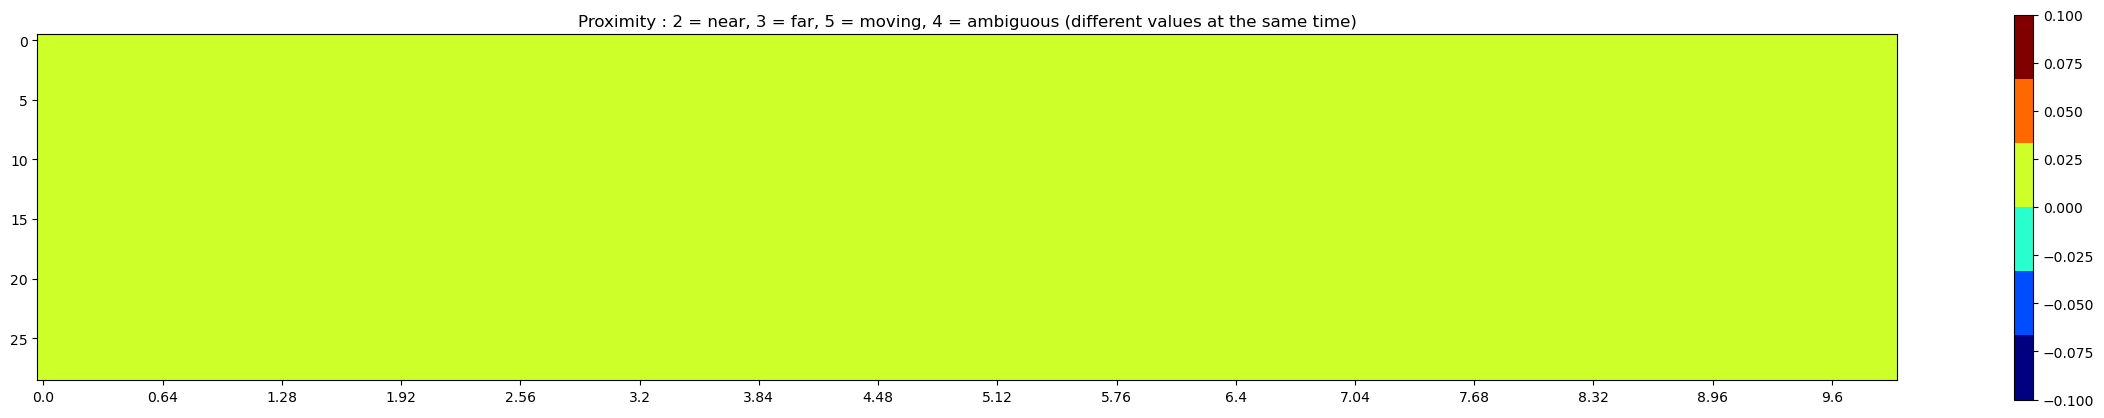

In [20]:
enc = encoder_fine_sn

strong_df = pd.read_csv(clips[ids[k]].annotation_path)[["annotator","event_label","proximity","onset", "offset"]]
encoded = encode_strong_df(enc, strong_df, "SINGA-PURA")
plt.figure(figsize=(30,5))
plt.imshow(encoded.T, cmap=plt.cm.get_cmap('jet', 6))
plt.colorbar()
plt.xticks(ticks = list(range(0,156,10)), labels=[encoder_coarse_sn._frame_to_time(x) for x in list(range(0,156,10))])
plt.title("Proximity : 2 = near, 3 = far, 5 = moving, 4 = ambiguous (different values at the same time)")
plt.show()

In [13]:
def update_prox_one_hot_list(prev_list, prox):
    prox_to_label = {'near':2,
                 'far':3,
                 'ambiguous':4,
                 'moving':5}
    
    new_label = prox_to_label[prox]
    new_list = np.copy(prev_list)
    
    
    for idx, prev_value in enumerate(prev_list):
        if prev_value == 0:
            new_list[idx] = new_label
        elif prev_value == new_label:
            continue
        elif prev_value != new_label:
            new_list[idx] = prox_to_label["ambiguous"]
        else:
            raise ValueError(f"unforeseen case : prev_value = {prev_value} and prox = {prox}")
    return new_list

def encode_strong_df(encoder, label_df, dset):
        """Encode a list (or pandas Dataframe or Serie) of strong labels, they correspond to a given filename

        Args:
            label_df: pandas DataFrame or Series, contains filename, onset (in frames) and offset (in frames)
                If only filename (no onset offset) is specified, it will return the event on all the frames
                onset and offset should be in frames
        Returns:
            numpy.array
            Encoded labels, 1 where the label is present, 0 otherwise
        """
        
        assert any(
            [x is not None for x in [encoder.audio_len, encoder.frame_len, encoder.frame_hop]]
        )

        samples_len = encoder.n_frames
        #if type(label_df) is str:
        #    if label_df == "empty":
        #        y = np.zeros((samples_len, len(encoder.labels))) - 1
        #        return y
        y = np.zeros((samples_len, len(encoder.labels)))
        if type(label_df) is pd.DataFrame:
            if {"onset", "offset", "event_label", "proximity"}.issubset(label_df.columns):
                for k, row in label_df.iterrows():
                    unified_label = encoder.taxonomy[dset][row["event_label"]]
                    if not pd.isna(row["event_label"]) and unified_label != "no-annotation":
                        i = encoder.labels.index(unified_label)
                        onset = int(encoder._time_to_frame(row["onset"]))
                        offset = int(np.ceil(encoder._time_to_frame(row["offset"])))
                        proximity = row["proximity"]
                        y[onset:offset, i] = update_prox_one_hot_list(y[onset:offset, i], proximity)  # means offset not included (hypothesis of overlapping frames, so ok)

        else:
            raise NotImplementedError(
                "To encode_strong, type is pandas.Dataframe with onset, offset and event_label"
                "columns,type given: {}".format(type(label_df))
            )
        return y

In [112]:
r_matrix1[:,::2].shape

(156, 96)

In [123]:
from ipywidgets import interact

In [154]:
@interact
def disp_rescale(k=10):
    plt.figure(figsize=(30,5))
    plt.imshow(gt_fine_SGP[k],cmap=plt.cm.get_cmap('jet', 6))
    plt.title("Proximity fine SGP : 2 = near, 3 = far, 5 = moving, 4 = ambiguous (different values at the same time)")
    plt.xticks(ticks = list(range(0,96,10)), labels=[round(encoder3._frame_to_time(x),3) for x in list(range(0,96,10))])
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(30,5))
    plt.imshow(gt_fine_SGP[k]@r_matrix_bis,cmap=plt.cm.get_cmap('jet', 6))
    plt.title("Proximity fine SGP : 2 = near, 3 = far, 5 = moving, 4 = ambiguous (different values at the same time)")
    plt.xticks(ticks = list(range(0,96,10)), labels=[round(encoder3._frame_to_time(x),3) for x in list(range(0,96,10))])
    plt.colorbar()
    plt.show()


interactive(children=(IntSlider(value=10, description='k', max=30, min=-10), Output()), _dom_classes=('widget-…

[0. 2. 5.]


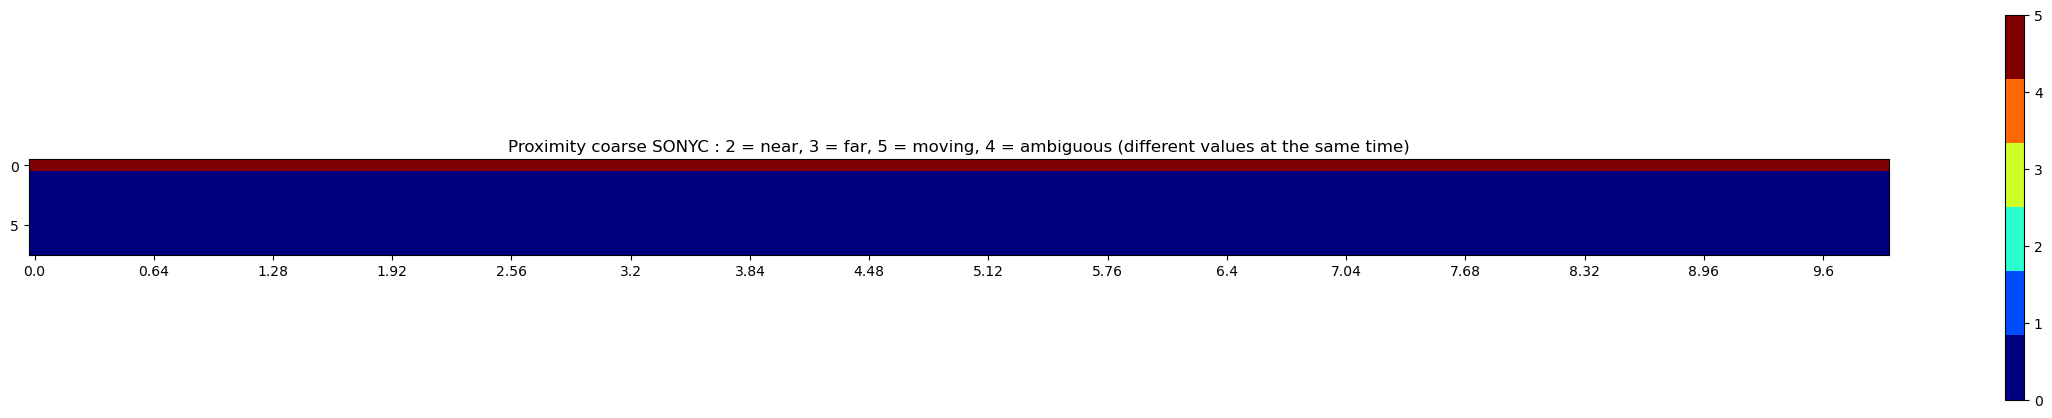

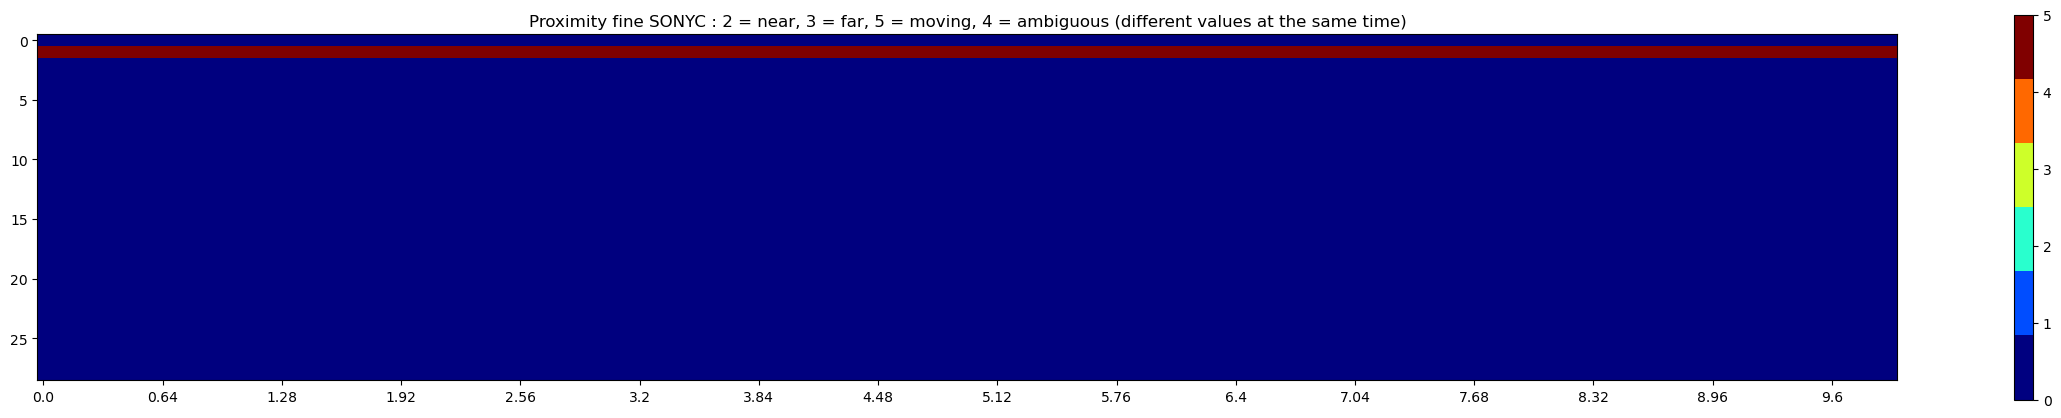

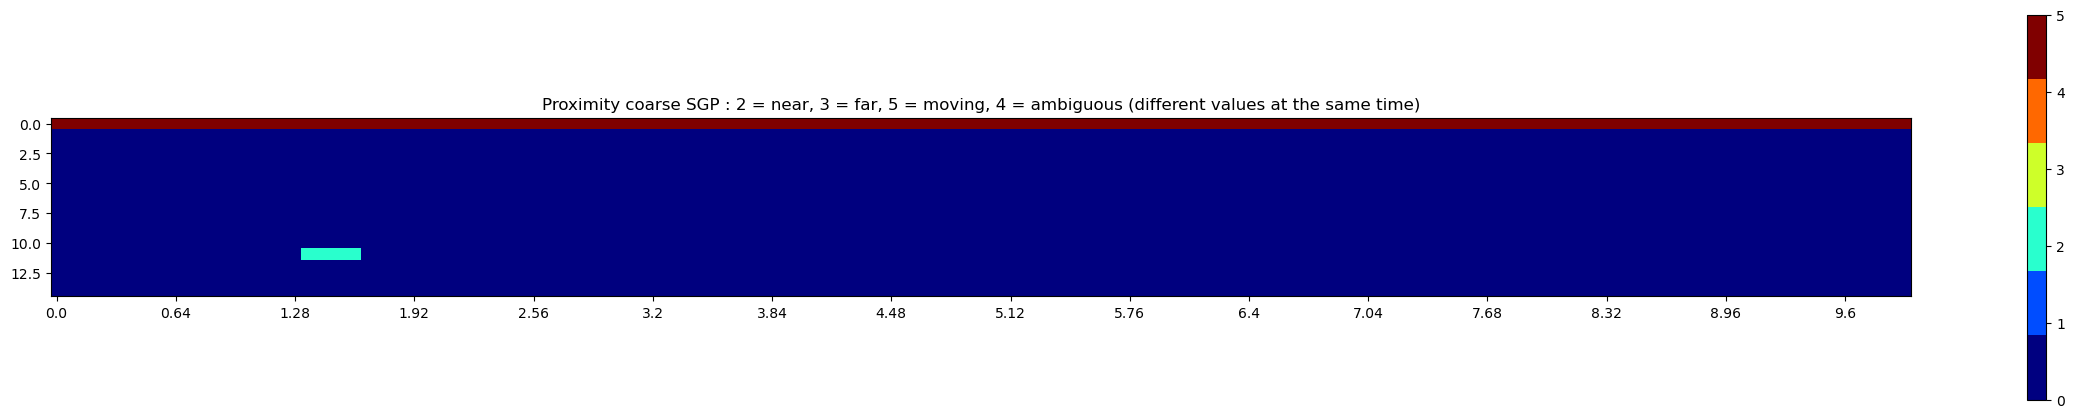

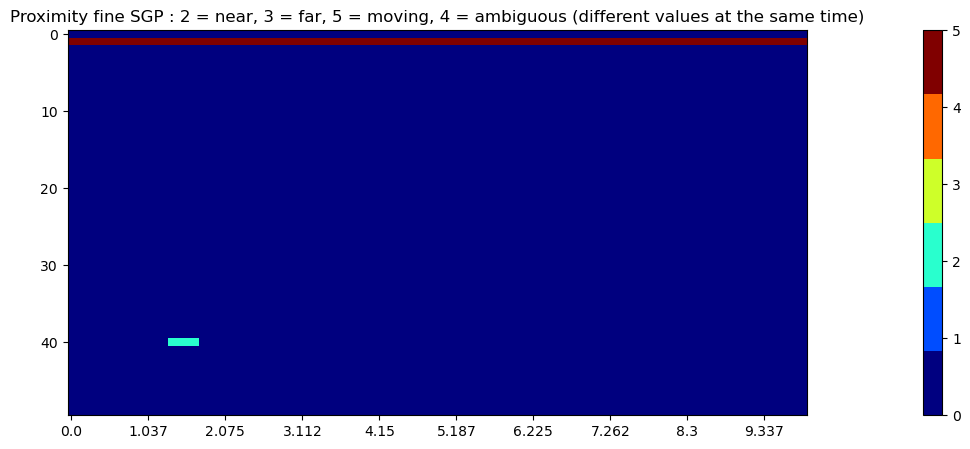

In [151]:
k=800
plt.figure(figsize=(30,5))
plt.imshow(gt_coarse_SONYC[k], cmap=plt.cm.get_cmap('jet', 6))
plt.title("Proximity coarse SONYC : 2 = near, 3 = far, 5 = moving, 4 = ambiguous (different values at the same time)")
plt.xticks(ticks = list(range(0,156,10)), labels=[encoder_coarse_sn._frame_to_time(x) for x in list(range(0,156,10))])
print(np.unique(gt_coarse_SGP[k]))
plt.colorbar()
plt.show()
plt.figure(figsize=(30,5))
plt.imshow(gt_fine_SONYC[k],cmap=plt.cm.get_cmap('jet', 6))
plt.title("Proximity fine SONYC : 2 = near, 3 = far, 5 = moving, 4 = ambiguous (different values at the same time)")
plt.xticks(ticks = list(range(0,156,10)), labels=[encoder_coarse_sn._frame_to_time(x) for x in list(range(0,156,10))])
plt.colorbar()
plt.show()
plt.figure(figsize=(30,5))
plt.imshow(gt_coarse_SGP[k],cmap=plt.cm.get_cmap('jet', 6))
plt.title("Proximity coarse SGP : 2 = near, 3 = far, 5 = moving, 4 = ambiguous (different values at the same time)")
plt.xticks(ticks = list(range(0,156,10)), labels=[encoder_coarse_sn._frame_to_time(x) for x in list(range(0,156,10))])
plt.colorbar()
plt.show()
plt.figure(figsize=(30,5))
plt.imshow(gt_fine_SGP[k]@r_matrix_bis,cmap=plt.cm.get_cmap('jet', 6))
plt.title("Proximity fine SGP : 2 = near, 3 = far, 5 = moving, 4 = ambiguous (different values at the same time)")
plt.xticks(ticks = list(range(0,96,10)), labels=[round(encoder3._frame_to_time(x),3) for x in list(range(0,96,10))])
plt.colorbar()
plt.show()



In [15]:
filenames = np.array(hf["SINGA-PURA"]["filenames"]).astype(str)
for k in tqdm(range(len(gt_coarse_SONYC))):
    '''
    get filename
    get csv
    encode csv for each taxo
    update hf
    '''
    fname = filenames[k]
    
    strong_df = pd.read_csv(clips[fname].annotation_path)[["event_label","proximity","onset", "offset"]]
    gt_coarse_SONYC[k] = encode_strong_df(encoder_coarse_sn, strong_df, "SINGA-PURA").T
    gt_fine_SONYC[k] = encode_strong_df(encoder_fine_sn, strong_df, "SINGA-PURA").T
    gt_coarse_SGP[k] = encode_strong_df(encoder_coarse_sgp, strong_df, "SINGA-PURA").T
    gt_fine_SGP[k] = encode_strong_df(encoder_fine_sgp, strong_df, "SINGA-PURA").T

100%|██████████| 1376/1376 [00:15<00:00, 87.92it/s] 


In [38]:
hf["SINGA-PURA"]["groundtruth"]["taxonomy_coarse_SINGA-PURA"][0].T

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [45]:
encoder_coarse_sgp.decode_strong(hf["SINGA-PURA"]["groundtruth"]["taxonomy_coarse_SINGA-PURA"][100])

[['engine', 0.0, 9.984],
 ['non-machinery-impact', 0.064, 0.256],
 ['non-machinery-impact', 0.384, 0.64],
 ['non-machinery-impact', 1.728, 2.112],
 ['non-machinery-impact', 6.912, 7.04],
 ['non-machinery-impact', 8.32, 8.448],
 ['human-voice', 1.152, 5.248],
 ['human-voice', 5.568, 9.984],
 ['animal', 0.0, 9.984]]

In [47]:
pd.DataFrame(encoder_coarse_sgp.decode_strong(hf["SINGA-PURA"]["groundtruth"]["taxonomy_coarse_SINGA-PURA"][100]), columns=['event_label','onset','offset'])

event_label  onset  offset
0                engine  0.000   9.984
1  non-machinery-impact  0.064   0.256
2  non-machinery-impact  0.384   0.640
3  non-machinery-impact  1.728   2.112
4  non-machinery-impact  6.912   7.040
5  non-machinery-impact  8.320   8.448
6           human-voice  1.152   5.248
7           human-voice  5.568   9.984
8                animal  0.000   9.984

In [46]:
group = hf["SINGA-PURA"]

In [49]:
ids = SONYC_test_set.ids
print(len(ids))
print(len(group["audio_32k"]))

664
1376


In [48]:
if len(ids) == len(group["audio_32k"]):
    print("ouais")
    group.create_dataset("filenames", data=ids)

ouais


In [57]:
hf_test["filenames_sg"][0:10].astype(str)[0]

'[b827ebbc6e34][2020-08-26T08-47-04Z][manual][---][de313d12d7f31937615be80cc47a1ad9][]-12'

In [15]:
for f in hf["SONYC"]["groundtruth"]:
    print(hf["SONYC"]["groundtruth"][f][9])

[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 1. 0. 0. 0.]
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


In [76]:
taxo_name = "taxonomy_coarse_SONYC"
with open(f"../config/{taxo_name}.yaml", "r") as f:
        taxonomy = yaml.safe_load(f)

In [77]:
encoder = ManyHotEncoder(
        taxonomy,
        audio_len=conf["data"]["audio_max_len"],
        frame_len=conf["features"]["n_filters"],
        frame_hop=conf["features"]["hop_length"],
        net_pooling=conf["data"]["net_subsample"],
        fs=conf["data"]["fs"],
    )

dataset = HDF5_SONYC_Dataset(
    conf["data"]["root_path"] + conf["data"][f"hdf5_{type_hf}"],
    conf["data"]["root_path"] + conf["data"][f"sonyc_csv_{type_hf}"],
    encoder,
    return_filename=True
)

In [99]:
print(set(taxonomy["class_labels"]))
print(set(taxonomy["SONYC"].values()))
print(set(taxonomy["SINGA-PURA"].values()))
print(len(taxonomy["class_labels"]))
print(len(set(taxonomy["SONYC"].values())))
print(len(set(taxonomy["SINGA-PURA"].values())))

{'non-machinery-impact', 'human-voice', 'engine', 'music', 'dog', 'machinery-impact', 'alert-signal', 'powered-saw'}
{'non-machinery-impact', 'human-voice', 'engine', 'music', 'dog', 'machinery-impact', 'no-annotation', 'alert-signal', 'powered-saw'}
{'non-machinery-impact', 'human-voice', 'engine', 'music', 'dog', 'machinery-impact', 'no-annotation', 'alert-signal', 'powered-saw'}
8
9
9


In [100]:
labels = np.zeros((len(dataset), len(taxonomy["class_labels"]),))
i = 0
for batch in dataset:
    labels[i] = batch[1]
    i+=1

In [101]:
print(len(dataset))
print(batch[1])
print(encoder.decode_weak(batch[1]))
print(labels.shape)

664
[0. 0. 0. 0. 0. 0. 0. 0.]
[]
(664, 8)


In [102]:
group = hf["SONYC"]
group.create_dataset(f"groundtruth/{taxo_name}", data=labels)

<HDF5 dataset "taxonomy_coarse_SONYC": shape (664, 8), type "<f8">

In [103]:
hf[f"SONYC"]["groundtruth"]

<HDF5 group "/SONYC/groundtruth" (4 members)>

In [12]:
hf.close()

In [213]:
SINGAPURA_train_set.ids[0]

'[b827ebbc6e34][2020-08-26T08-47-04Z][manual][---][de313d12d7f31937615be80cc47a1ad9][]-12'

In [97]:
SINGAPURA_train_set.ids[500]

'[b827eb0a63c9][2020-08-30T10-33-04Z][manual][---][de313d12d7f31937615be80cc47a1ad9][]-826'

In [20]:
i=0
for batch in SINGAPURA_train_set:
    assert batch[1].shape == (8, 156)

In [13]:
test = np.zeros((8,9))
test = test.transpose()
test.shape

(9, 8)

In [36]:
SINGAPURA_val_set = HDF5_SINGAPURA_labelled(
    conf["data"]["root_path"] + conf["data"]["hdf5_val"],
    conf["data"]["root_path"] + conf["data"]["singa-pura_csv_val"],
    encoder,
    return_filename=True,
    taxonomy=taxonomy
)

In [27]:
SONYC_train_set = HDF5_SONYC_Dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_train"],
    conf["data"]["root_path"] + conf["data"]["sonyc_csv_train"],
    encoder,
    return_filename=True
)

In [37]:
SONYC_val_set = HDF5_SONYC_Dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_val"],
    conf["data"]["root_path"] + conf["data"]["sonyc_csv_val"],
    encoder,
    return_filename=True
)

In [38]:
SINGAPURA_test_set = HDF5_SINGAPURA_labelled(
    conf["data"]["root_path"] + conf["data"]["hdf5_test"],
    conf["data"]["root_path"] + conf["data"]["singa-pura_csv_test"],
    encoder,
    return_filename=True,
)

SONYC_test_set = HDF5_SONYC_Dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_test"],
    conf["data"]["root_path"] + conf["data"]["sonyc_csv_test"],
    encoder,
    return_filename=True,
)
test_dataset = torch.utils.data.ConcatDataset([SINGAPURA_test_set, SONYC_test_set])


In [16]:
test_dataset.datasets[0] == SINGAPURA_test_set

True

In [39]:
durations, groundtruths = SINGAPURA_val_set._generate_eval_dfs(taxonomy)

In [43]:
SINGAPURA_val_set.groundtruths

filename  onset  offset  \
0     [b827eb0ebf2f][2020-10-27T09-55-14Z][manual][-...  0.960   1.216   
1     [b827eb0ebf2f][2020-10-27T09-55-14Z][manual][-...  3.840   4.224   
2     [b827eb0ebf2f][2020-10-27T09-55-14Z][manual][-...  4.608   4.800   
3     [b827eb0ebf2f][2020-10-27T09-55-14Z][manual][-...  6.976   7.168   
4     [b827eb0ebf2f][2020-10-27T09-55-14Z][manual][-...  7.616   7.808   
...                                                 ...    ...     ...   
2208  [b827eb0ebf2f][2020-10-30T02-19-14Z][manual][-...  5.248   9.984   
2209  [b827eb0ebf2f][2020-10-30T02-19-14Z][manual][-...  0.704   1.536   
2210  [b827eb0ebf2f][2020-10-30T02-19-14Z][manual][-...  4.288   5.312   
2211  [b827eb0ebf2f][2020-10-30T02-19-14Z][manual][-...  5.504   7.936   
2212  [b827eb0ebf2f][2020-10-30T02-19-14Z][manual][-...  8.960   9.984   

               event_label  
0     non-machinery-impact  
1     non-machinery-impact  
2     non-machinery-impact  
3     non-machinery-impact  
4     non-machinery-impact  
...                    ...  
2208      machinery-impact  
2209          alert-signal  
2210           human-voice  
2211           human-voice  
2212           human-voice  

[2213 rows x 4 columns]

In [28]:
df_sonyc_train = pd.read_csv("/tsi/doctorants/fangulo/Detection-Urban/data/metadata/train/SONYC_train.csv")
df_sonyc_val = pd.read_csv("/tsi/doctorants/fangulo/Detection-Urban/data/metadata/val/SONYC_val.csv")

In [65]:
dset = soundata.initialize("singapura", "/tsi/dcase/SINGA-PURA")
ids = dset.clip_ids  # the list of urbansound8k's clip ids
clips = dset.load_clips()  # Load all clips in the dataset

In [73]:
clips[SINGAPURA_train_set.ids[1]].events.annotations[0].labels

['3-0', '3-0', '1-2', '9-2']

In [83]:
SINGAPURA_train_set[1][1]

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
idx = np.random.randint(400)
audio, labels, filename = SONYC_train_set[idx]
print(idx)
print(labels.shape)
print(labels[:, 0])
print(np.where(labels))
print(filename)
print(df_sonyc_train[df_sonyc_train["filename"]==filename])

239
(8, 156)
[1. 0. 0. 0. 0. 0. 0. 0.]
(array([0]), array([0]))
01_004295.wav
          filename   event_labels
239  01_004295.wav  1-2;1-3;1;1-X


In [53]:
labels_dataset = np.zeros((300,8))
labels[:,0]
labels_dataset[0]=labels[:,0]

In [54]:
labels_dataset

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
for audio, labels, filename in SONYC_train_set:
    print(labels)

NameError: name 'SONYC_train_set' is not defined

255
torch.Size([10, 156])
[b827ebb954cd][2020-08-23T13-07-04Z][manual][---][de313d12d7f31937615be80cc47a1ad9][]-1510
['1-3', '3-0', '3-0', '12-1']
[0.    3.508 4.207 5.284]
[10.     3.821  4.545  6.478]


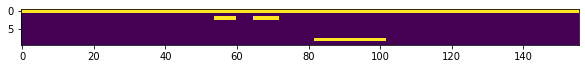

In [335]:
idx = np.random.randint(400)
audio, labels, filename = SINGAPURA_train_set[idx]
print(idx)
print(labels.shape)
print(filename)
print(clips[filename].events.annotations[0].labels)
print(clips[filename].events.annotations[0].intervals[:,0])
print(clips[filename].events.annotations[0].intervals[:,1])
plt.figure(figsize=(10,5))
plt.imshow(labels)
plt.show()

## Computing HDF5 SONYC

In [39]:
type_hf = "train"
sonyc_gt = pd.read_csv(f"../data/metadata/{type_hf}/SONYC_{type_hf}.csv")
print(sonyc_gt)

            filename                 event_labels
0      01_000006.wav                        8-1;8
1      01_000038.wav                  8-1;7-1;8;7
2      01_000061.wav              5;6;6-X;5-1;6-1
3      01_000126.wav                    7-1;7-2;7
4      01_000143.wav            7-4;7-2;7;7-1;7-3
...              ...                          ...
12973  45_009593.wav  4-1;1-3;5;2;4;5-1;1-X;1;2-2
12974  45_009956.wav          5;1-3;5-1;1-2;1-1;1
12975  45_009986.wav                  1-3;1;4-X;4
12976  45_013176.wav                  6;1-3;1;6-X
12977  45_020822.wav  5;1-3;5-3;4;4-2;3;1-X;1;3-1

[12978 rows x 2 columns]


NameError: name 'dtale' is not defined

In [8]:
def get_subset_split(annotation_data):
    """
    Get indices for train and validation subsets
    Parameters
    ----------
    annotation_data
    Returns
    -------
    train_idxs
    valid_idxs
    """

    # Get the audio filenames and the splits without duplicates
    data = annotation_data[['split', 'audio_filename', 'annotator_id']]\
                          .groupby(by=['split', 'audio_filename'], as_index=False)\
                          .min()\
                          .sort_values('audio_filename')

    train_idxs = []
    valid_idxs = []
    test_idxs = []

    for idx, (_, row) in enumerate(data.iterrows()):
        if row['split'] == 'train':
            train_idxs.append(idx)
        elif row['split'] == 'validate' and row['annotator_id'] <= 0:
            # For validation examples, only use verified annotations
            valid_idxs.append(idx)
        elif row['split'] == 'test' and row['annotator_id'] <= 0:
            # For validation examples, only use verified annotations
            test_idxs.append(idx)

    return np.array(train_idxs), np.array(valid_idxs), np.array(test_idxs)

In [29]:
annot_sonyc = pd.read_csv(dconf['sonyc']['annotations']).sort_values('audio_filename')
subset_split = get_subset_split(annot_sonyc)

NameError: name 'dconf' is not defined

In [53]:
dtale.show(annot_sonyc.iloc[subset_split[2]])

In [54]:
data = annot_sonyc[['split', 'audio_filename', 'annotator_id']]\
                          .groupby(by=['split', 'audio_filename'], as_index=False)\
                          .min()\
                          .sort_values('audio_filename')

In [55]:
data

split audio_filename  annotator_id
14202  validate  00_000066.wav            -5
14203  validate  00_000071.wav            64
14204  validate  00_000085.wav            64
14205  validate  00_000118.wav            -4
14206  validate  00_000179.wav            64
...         ...            ...           ...
659        test  58_027562.wav            -6
660        test  61_027412.wav            -6
661        test  61_027621.wav            -5
662        test  61_027651.wav            -6
663        test  61_027827.wav            -6

[18510 rows x 3 columns]

In [20]:
train_idxs = []
valid_idxs = []
test_idxs = []

for idx, (_, row) in enumerate(data.iterrows()):
    print(idx)
    if row['split'] == 'train':
        train_idxs.append(idx)
    elif row['split'] == 'validate' and row['annotator_id'] <= 0:
        # For validation examples, only use verified annotations
        valid_idxs.append(idx)
    elif row['split'] == 'test' and row['annotator_id'] <= 0:
        # For validation examples, only use verified annotations
        test_idxs.append(idx)

NameError: name 'data' is not defined

In [28]:
def parse_ground_truth(annotation_path, yaml_path, split="validate", type_annot="verified"):
    """
    Parse ground truth annotations from a CSV file containing both fine-level
    and coarse-level predictions (and possibly additional metadata).
    Returns a Pandas DataFrame in which the column names are coarse
    IDs of the form 1, 2, 3 etc.
    Parameters
    ----------
    annotation_path: string
        Path to the CSV file containing predictions.
    yaml_path: string
        Path to the YAML file containing coarse taxonomy.
    Returns
    -------
    gt_df: DataFrame
        Ground truth.
    """
    # Create dictionary to parse tags
    with open(yaml_path, 'r') as stream:
        yaml_dict = yaml.load(stream, Loader=yaml.Loader)

    # Load CSV file into a Pandas DataFrame.
    ann_df = pd.read_csv(annotation_path)
    
    if type_annot == "verified":
        # Restrict to ground truth ("annotator zero").
        gt_df = ann_df[
            (ann_df["annotator_id"]==0) & (ann_df["split"]==split)]
    elif type_annot == "crowdsourced":
        gt_df = ann_df[
            (ann_df["annotator_id"] != 0) & (ann_df["split"]==split)]
    elif type_annot == "all":
        gt_df = ann_df[
            ann_df["split"]==split]
    
    # Rename coarse columns.
    coarse_dict = yaml_dict["coarse"]
    coarse_renaming = {
        "_".join([str(c), coarse_dict[c], "presence"]): str(c)
        for c in coarse_dict}
    gt_df = gt_df.rename(columns=coarse_renaming)

    # Collect tag names as strings and map them to mixed (coarse-fine) ID pairs.
    # The "mixed key" is a hyphenation of the coarse ID and fine ID.
    fine_dict = {}
    for coarse_id in yaml_dict["fine"]:
        for fine_id in yaml_dict["fine"][coarse_id]:
            mixed_key = "-".join([str(coarse_id), str(fine_id)])
            fine_dict[mixed_key] = yaml_dict["fine"][coarse_id][fine_id]

    # Rename fine columns.
    fine_renaming = {"_".join([k, fine_dict[k], "presence"]): k
        for k in fine_dict}
    gt_df = gt_df.rename(columns=fine_renaming)

    # Loop over coarse tags.
    n_samples = len(gt_df)
    coarse_dict = yaml_dict["coarse"]
    for coarse_id in yaml_dict["coarse"]:
        # Construct incomplete fine tag by appending -X to the coarse tag.
        incomplete_tag = str(coarse_id) + "-X"

        # If the incomplete tag is not in the prediction, append a column of zeros.
        # This is the case e.g. for coarse ID 7 ("dogs") which has a single
        # fine-level tag ("7-1_dog-barking-whining") and thus no incomplete
        # tag 7-X.
        if incomplete_tag not in gt_df.columns:
            gt_df[incomplete_tag] = np.zeros((n_samples,)).astype('int')

    # Return output in DataFrame format.
    return gt_df.sort_values('audio_filename')

In [29]:
dtale.show(parse_ground_truth(dconf['sonyc']['annotations'], dconf['sonyc']['taxonomy']))

## Transforming dataframes into simpler ones 
Audio tagging : (filename, tags) <br>
SED : filename, (onset, offset, label)

In [30]:
gt_df = parse_ground_truth(dconf['sonyc']['annotations'], dconf['sonyc']['taxonomy'], split="test", type_annot="verified")
dtale.show(gt_df)
                              

In [31]:
labels = list(gt_df.columns)
print(labels)
print(labels[12:41] + labels[-10:])

['split', 'sensor_id', 'audio_filename', 'annotator_id', 'borough', 'block', 'latitude', 'longitude', 'year', 'week', 'day', 'hour', '1-1', '1-2', '1-3', '1-X', '2-1', '2-2', '2-3', '2-4', '2-X', '3-1', '4-1', '4-2', '4-3', '4-X', '5-1', '5-2', '5-3', '5-4', '5-X', '6-1', '6-2', '6-3', '6-X', '7-1', '7-2', '7-3', '7-4', '7-X', '8-1', '1-1_small-sounding-engine_proximity', '1-2_medium-sounding-engine_proximity', '1-3_large-sounding-engine_proximity', '1-X_engine-of-uncertain-size_proximity', '2-1_rock-drill_proximity', '2-2_jackhammer_proximity', '2-3_hoe-ram_proximity', '2-4_pile-driver_proximity', '2-X_other-unknown-impact-machinery_proximity', '3-1_non-machinery-impact_proximity', '4-1_chainsaw_proximity', '4-2_small-medium-rotating-saw_proximity', '4-3_large-rotating-saw_proximity', '4-X_other-unknown-powered-saw_proximity', '5-1_car-horn_proximity', '5-2_car-alarm_proximity', '5-3_siren_proximity', '5-4_reverse-beeper_proximity', '5-X_other-unknown-alert-signal_proximity', '6-1_sta

In [230]:
columns = list(gt_df.columns)
labels = columns[12:41] + columns[-10:]
weak_dict_set = defaultdict(set)

for _, row in gt_df.iterrows():
    for l in labels:
        if row[l]:
            weak_dict_set[row['audio_filename']].add(l)

weak_dict = {k:list(v) for k,v in weak_dict_set.items()}
for fname in gt_df["audio_filename"].unique():
    if fname not in weak_dict.keys():
        weak_dict[fname] = '0'

weak_dict_str = {k: ';'.join(v) for k,v in weak_dict.items()}

In [57]:
df_weak = pd.DataFrame.from_dict({'filename':weak_dict_str.keys(), 'event_labels':weak_dict_str.values()})



NameError: name 'weak_dict_str' is not defined

In [234]:
#df_weak.to_csv('../data/metadata/test/SONYC_test.csv')

In [52]:
labels = []
for idx in ids:
    for l in clips[idx].events.annotations[0].labels:
        if l not in labels:
            labels.append(l)
labels.sort()
print(labels)
#    if '0-3' in clips[idx].events.annotations[0].labels:
#        raise ValueError(f"Filename {idx} has wrong label")

['0-0', '0-1', '0-2', '0-3', '0-4', '1-0', '1-1', '1-2', '1-3', '10-0', '10-1', '11-1', '11-2', '11-3', '12-1', '12-2', '13-1', '13-2', '2-0', '2-1', '2-2', '2-3', '2-4', '3-0', '3-1', '3-3', '4-0', '4-1', '4-2', '4-3', '5-0', '5-1', '5-2', '5-3', '5-4', '6-0', '6-1', '6-2', '7-0', '7-1', '7-2', '7-3', '7-4', '7-5', '8-0', '8-1', '8-2', '9-0', '9-1', '9-2', '9-3']


In [49]:
clips["[b827ebd63759][2020-10-28T00-30-24Z][manual][---][4edbade2d41d5f80e324ee4f10d401c0]"].events.annotations[0].labels

['3-0', '0-3', '3-0', '0-3', '0-3', '0-3', '3-0', '8-1', '7-3', '7-1', '7-1']

In [44]:
example_clip = clips[ids[0]]  # Get the first clip

In [35]:
ids

['[b827eb7d576e][2020-08-03T23-32-11Z][manual][---][565a40f866f3d2804332ca7896a4c77d][93.29-86.29 66.65]!-90',
 '[b827eb3e52b8][2020-08-17T12-48-04Z][manual][---][8c6c82299281cc924f9ef00b61f91081][]-1562',
 '[b827eb3e52b8][2020-08-17T13-26-04Z][manual][---][8c6c82299281cc924f9ef00b61f91081][]-1737',
 '[b827eb3e52b8][2020-08-17T13-33-04Z][manual][---][8c6c82299281cc924f9ef00b61f91081][]-1761',
 '[b827eb3e52b8][2020-08-17T13-45-05Z][manual][---][8c6c82299281cc924f9ef00b61f91081][]-1831',
 '[b827eb3e52b8][2020-08-17T14-27-05Z][manual][---][8c6c82299281cc924f9ef00b61f91081][]-1981',
 '[b827eb3e52b8][2020-08-17T14-49-04Z][manual][---][8c6c82299281cc924f9ef00b61f91081][]-2004',
 '[b827eb3e52b8][2020-08-17T14-58-04Z][manual][---][8c6c82299281cc924f9ef00b61f91081][]-2017',
 '[b827eb3e52b8][2020-08-17T15-12-04Z][manual][---][8c6c82299281cc924f9ef00b61f91081][]-2033',
 '[b827eb3e52b8][2020-08-17T15-48-04Z][manual][---][8c6c82299281cc924f9ef00b61f91081][]-2056',
 '[b827eb3e52b8][2020-08-17T15-59-

In [9]:
clips[ids[0]].clip_id == ids[0]

True

## Transforming SINGA-PURA dataframes into train/val/test split

In [12]:
df_sgp = pd.read_csv(conf['singa-pura']['annotations_recording'])
sensor_ids = ['b827eb0ebf2f', 'b827eb7680c5','b827eb3e52b8']
df_sgp_train = df_sgp[(~df_sgp["sensor_id"].isin(sensor_ids)) & ((df_sgp["month"] != 8) | (df_sgp["date"] > 21))].reset_index()
df_sgp_val = df_sgp[(df_sgp["sensor_id"].isin(sensor_ids)) & ((df_sgp["month"] != 8) | (df_sgp["date"] > 21))].reset_index()
df_sgp_test = df_sgp[(df_sgp["date"] <= 21) & (df_sgp["month"]==8)].reset_index()
print(len(df_sgp_train), len(df_sgp_test), len(df_sgp_val))
len(df_sgp_train)+len(df_sgp_test)+len(df_sgp_val)

df_sgp_train["clip_id"] = df_sgp_train["filename"].apply(lambda x : x.replace(".flac", ""))
df_sgp_val["clip_id"] = df_sgp_val["filename"].apply(lambda x : x.replace(".flac", ""))
df_sgp_test["clip_id"] = df_sgp_test["filename"].apply(lambda x : x.replace(".flac", ""))

df_sgp_train["filename"] = df_sgp_train["foldername"] + "/" + df_sgp_train["filename"]
df_sgp_val["filename"] = df_sgp_val["foldername"] + "/" + df_sgp_val["filename"]
df_sgp_test["filename"] = df_sgp_test["foldername"] + "/" + df_sgp_test["filename"]





dtale.show(df_sgp_train[["filename","clip_id"]])

4435 1376 736


In [13]:
df_sgp_train[["filename","clip_id"]].to_csv("../data/metadata/train/SINGA-PURA_train.csv", index=False)
df_sgp_val[["filename","clip_id"]].to_csv("../data/metadata/val/SINGA-PURA_val.csv", index=False)
df_sgp_test[["filename","clip_id"]].to_csv("../data/metadata/test/SINGA-PURA_test.csv", index=False)

Executing shutdown due to inactivity...
Executing shutdown due to inactivity...


2022-05-11 18:46:19,232 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...
Executing shutdown...


2022-05-11 18:46:19,251 - INFO     - Executing shutdown...


In [25]:
idx = np.random.randint(0,500)
onset = clips[df_sgp_train["clip_id"][idx]].events.annotations[0].intervals[:,0]
offset = clips[df_sgp_train["clip_id"][idx]].events.annotations[0].intervals[:,1]
label = clips[df_sgp_train["clip_id"][idx]].events.annotations[0].labels


In [26]:
pd.DataFrame({"onset":onset, "offset":offset, "label": label})

onset  offset label
0  1.307   1.709   3-0
1  2.337   2.740   3-0
2  6.558   7.060   3-0
3  0.000  10.000  11-3

In [121]:
df_sgp_train[["filename","clip_id"]].to_csv("/tsi/doctorants/fangulo/Detection-Urban/data/metadata/train/SINGA-PURA_train.csv", index=False)
df_sgp_val[["filename","clip_id"]].to_csv("/tsi/doctorants/fangulo/Detection-Urban/data/metadata/val/SINGA-PURA_val.csv", index=False)
df_sgp_test[["filename","clip_id"]].to_csv("/tsi/doctorants/fangulo/Detection-Urban/data/metadata/test/SINGA-PURA_test.csv", index=False)

In [56]:
hf = h5py.File("../data/train.h5", "r")

In [67]:
list(hf["SONYC"].keys())

['audio_32k']

In [31]:
list(hf.keys())

['SINGA-PURA', 'SONYC', 'unlabelled_SINGA-PURA']

Executing shutdown due to inactivity...


2022-05-06 13:52:18,002 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2022-05-06 13:52:18,036 - INFO     - Executing shutdown...


In [77]:
Audio(hf["SONYC"]["audio_32k"][189], rate=32000)

In [75]:
df_sn = pd.read_csv("../data/metadata/train/SONYC_train.csv")

In [82]:
df_sn.iloc[[189]]

filename event_labels
189  01_003300.wav        8-1;8

In [83]:
df_sn

filename                 event_labels
0      01_000006.wav                        8-1;8
1      01_000038.wav                  8-1;7-1;8;7
2      01_000061.wav              5;6;6-X;5-1;6-1
3      01_000126.wav                    7-1;7-2;7
4      01_000143.wav            7-4;7-2;7;7-1;7-3
...              ...                          ...
12973  45_009593.wav  4-1;1-3;5;2;4;5-1;1-X;1;2-2
12974  45_009956.wav          5;1-3;5-1;1-2;1-1;1
12975  45_009986.wav                  1-3;1;4-X;4
12976  45_013176.wav                  6;1-3;1;6-X
12977  45_020822.wav  5;1-3;5-3;4;4-2;3;1-X;1;3-1

[12978 rows x 2 columns]

In [99]:
df_unlabelled = pd.read_csv("/tsi/dcase/SINGA-PURA/unlabelled_metadata_public_with_folder.csv")
del df_unlabelled["Unnamed: 0"]
df_unlabelled.to_csv("/tsi/dcase/SINGA-PURA/unlabelled_metadata_public_with_folder.csv", index=False)

In [87]:
dtale.show(df_unlabelled)

In [88]:
df_unlabelled["filename"] = df_unlabelled["foldername"]

Unnamed: 0     sensor_id  \
0               0  b827eb0746c4   
1               1  b827eb0746c4   
2               2  b827eb0746c4   
3               3  b827eb0746c4   
4               4  b827eb0746c4   
...           ...           ...   
72401       72401  b827ebd63759   
72402       72402  b827ebd63759   
72403       72403  b827ebd63759   
72404       72404  b827ebd63759   
72405       72405  b827ebd63759   

                                                filename  foldername  year  \
0      [b827eb0746c4][2020-07-15T04-16-00Z][manual][-...  2020-07-15  2020   
1      [b827eb0746c4][2020-07-15T06-07-04Z][manual][-...  2020-07-15  2020   
2      [b827eb0746c4][2020-07-15T06-07-14Z][manual][-...  2020-07-15  2020   
3      [b827eb0746c4][2020-07-15T06-07-24Z][manual][-...  2020-07-15  2020   
4      [b827eb0746c4][2020-07-15T06-07-34Z][manual][-...  2020-07-15  2020   
...                                                  ...         ...   ...   
72401  [b827ebd63759][2020-11-30T23-48-25Z][manual][-...  2020-11-30  2020   
72402  [b827ebd63759][2020-11-30T23-48-35Z][manual][-...  2020-11-30  2020   
72403  [b827ebd63759][2020-11-30T23-51-06Z][manual][-...  2020-11-30  2020   
72404  [b827ebd63759][2020-11-30T23-51-16Z][manual][-...  2020-11-30  2020   
72405  [b827ebd63759][2020-11-30T23-51-26Z][manual][-...  2020-11-30  2020   

       month  date  day  hour  minute  second timezone    town  
0          7    15    3    12      16       0      SGT  West 1  
1          7    15    3    14       7       4      SGT  West 1  
2          7    15    3    14       7      14      SGT  West 1  
3          7    15    3    14       7      24      SGT  West 1  
4          7    15    3    14       7      34      SGT  West 1  
...      ...   ...  ...   ...     ...     ...      ...     ...  
72401     12     1    2     7      48      25      SGT  West 1  
72402     12     1    2     7      48      35      SGT  West 1  
72403     12     1    2     7      51       6      SGT  West 1  
72404     12     1    2     7      51      16      SGT  West 1  
72405     12     1    2     7      51      26      SGT  West 1  

[72406 rows x 13 columns]

In [93]:
df_unlabelled["filename"] = df_unlabelled["foldername"] +  "/" + df_unlabelled["filename"]

In [96]:
df_unlabelled["filename"].to_csv("../data/metadata/train/SINGA-PURA_unlabelled.csv", index=False)

In [127]:
test.create_dataset("SONYC/audio", data=np.ones((41,50)))
test.close()

In [136]:
test = h5py.File("test.h5", "r")
test["SONYC"]["melspec"][10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

Executing shutdown due to inactivity...


2022-05-05 19:52:43,456 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2022-05-05 19:52:43,541 - INFO     - Executing shutdown...
